## Load dependencies

In [1]:
import os
os.chdir("../..")

from src.imports import *
from src.params import *

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [2]:
mlflow_optuna_name = f'V4_{TISSUE_TYPE}__3xMultimodal_Vali_BP'
mlflow_test_name   = f'V4_{TISSUE_TYPE}__3xMultimodal_Test_BM'

In [3]:
# Configure MlFlow and Optuna Callback
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name=mlflow_optuna_name)
experiment = mlflow.get_experiment_by_name(mlflow_optuna_name)
experiment_id = experiment.experiment_id

mlflc = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="loss",
    create_experiment=False,
)

2024/03/11 16:12:57 INFO mlflow.tracking.fluent: Experiment with name 'V4_Lung__3xMultimodal_Vali_BP' does not exist. Creating a new experiment.
/var/folders/wb/w_wgvy9j76bgddxv8j5nxw4c0000gn/T/ipykernel_96424/340159736.py:7: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(


In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn._oldcore')

## Load data

[-] Duplicated subjects found on histology. Keeping the first of each: ['GTEX-14A6H', 'GTEX-1I6K6', 'GTEX-1JK1U']
[-] Duplicated subjects found on histology. Keeping the first of each: ['GTEX-14A6H', 'GTEX-1I6K6', 'GTEX-1JK1U']
[-] Duplicated subjects found on histology. Keeping the first of each: ['GTEX-14A6H', 'GTEX-1I6K6', 'GTEX-1JK1U']


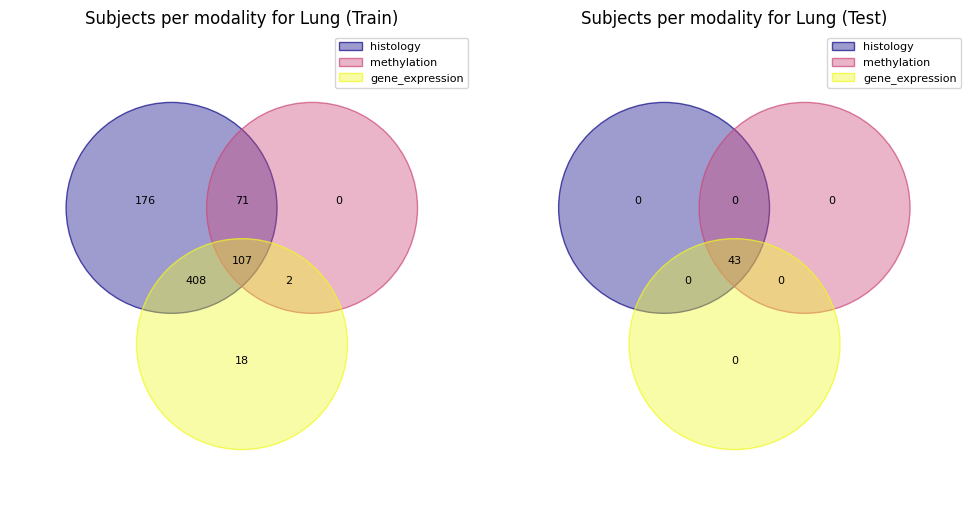

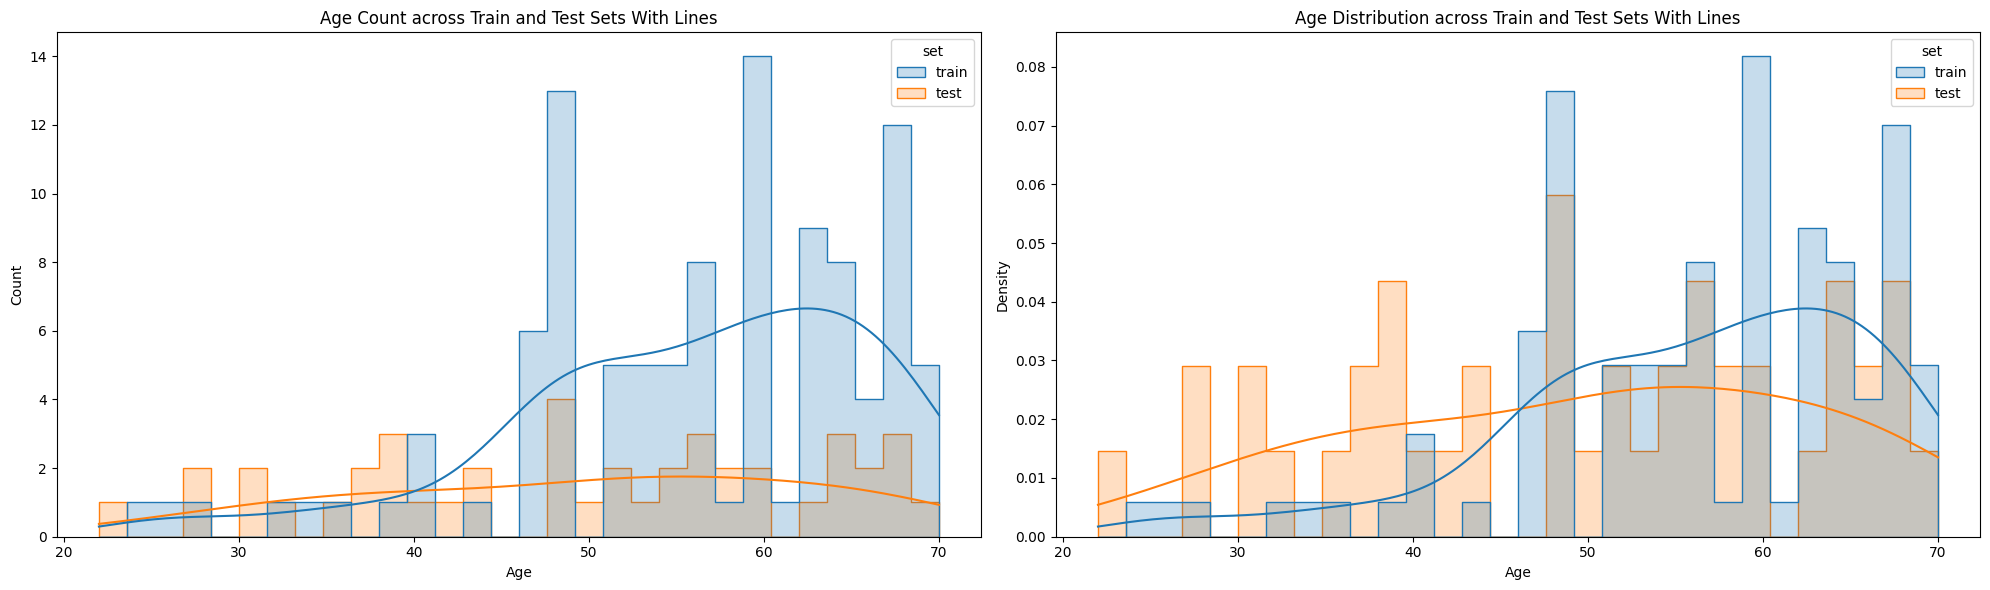

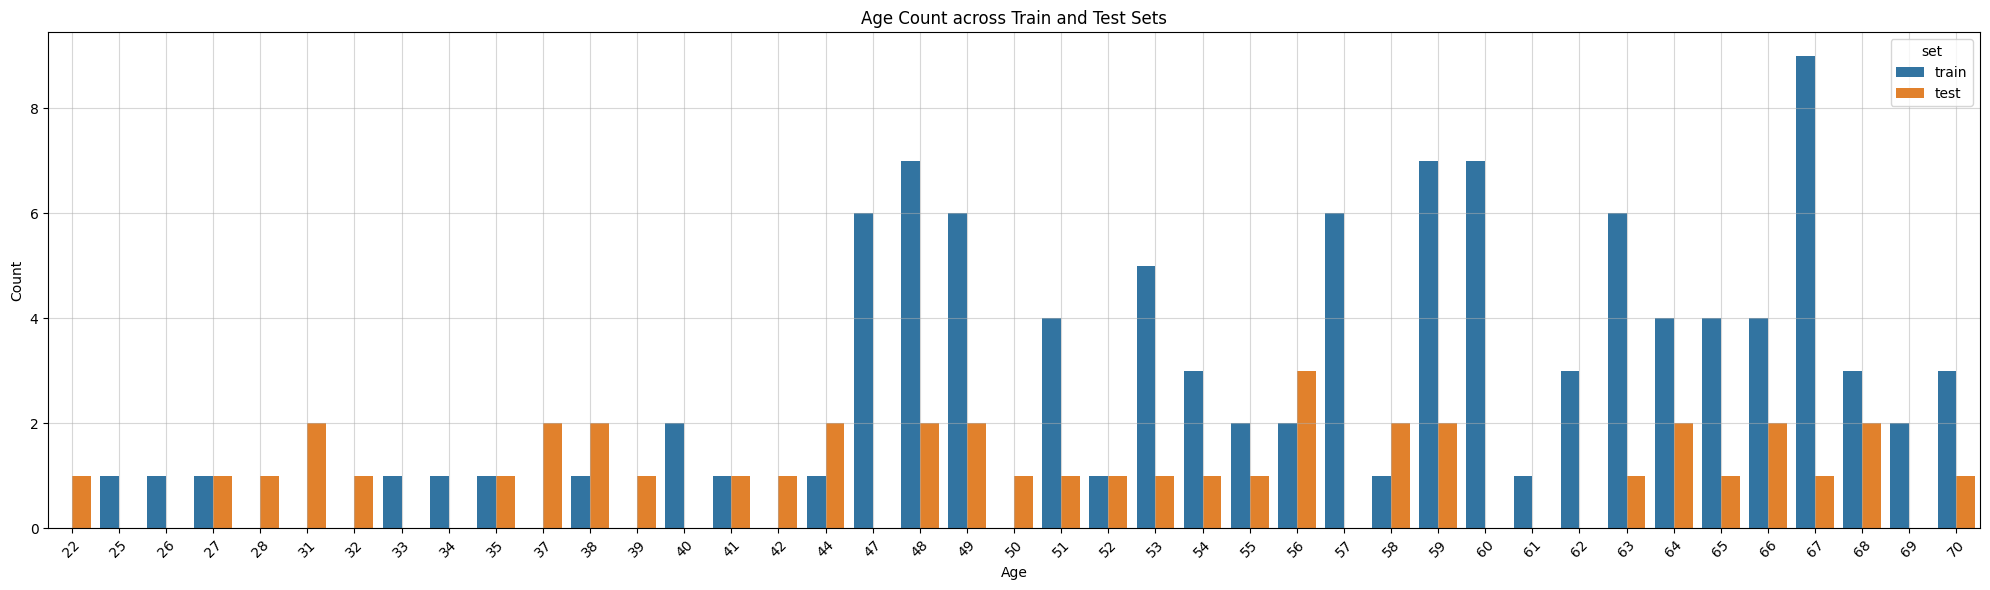

In [5]:
# Get train subjects
df_sids_test = pd.read_csv(path__test_sample)
df_sids_test = df_sids_test.groupby("sample_id")["age"].max()
test_subjects = list(set(pd.Series(df_sids_test.index).apply(lambda x: "-".join(x.split("-")[:-1]))))

# Specify modalities to load
modalities = ["histology", "methylation", "gene_expression"]

# Initialize class
mm = GTExMultiData(TISSUE_TYPE, modalities)

# Get torch tensors, filtering out subjects without age
tensor__gene, sid__gene = mm.get_gene(intersec=True, split=test_subjects, filter_on="age")
tensor__meth, sid__meth = mm.get_meth(intersec=True, split=test_subjects, filter_on="age")
tensor__hist, sid__hist = mm.get_hist(intersec=True, split=test_subjects, filter_on="age")

# Get train/teste labels (labels should be the same for any modality)
y_train = mm.get_labels(sid__hist[0], label="age")
y_test  = mm.get_labels(sid__hist[1], label="age")

# Plot intersections between modalities
mm.intersection(split=test_subjects)

# Plot the age distribution between train and test sets
plots.plot_age_data(y_train, y_test)

## Cross Validation

In [6]:
matplotlib.use('Agg')

In [7]:
def get_custom_loss(name):
    from inspect import getmembers, isfunction
    lt_methods = getmembers(ls, isfunction)
    return dict(lt_methods)[name]


In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
def safe_metric_calculation(target, prediction, metric_function):
    try:
        return metric_function(target, prediction)
    except ValueError:
        return np.nan

In [10]:
from torch import nn, optim
from tqdm import tqdm

def train_one_epoch(model, modalities, train_loaders, optimizer, loss_custom, DEVICE):
    model.train()
    train_loss = 0.0
    for batch in zip(*train_loaders):
        reference_labels = batch[0][1]
        reference_weights = batch[0][2]

        for b in batch[1:]:
            assert torch.equal(reference_labels, b[1]), "Labels across modalities do not match"
            assert torch.equal(reference_weights, b[2]), "Weights across modalities do not match"

        inputs = {modality: batch[idx][0].to(DEVICE) for idx, modality in enumerate(modalities)}
        labels = reference_labels.to(DEVICE)
        weights = reference_weights.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_custom(outputs.squeeze(), labels, weights=weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

    total_samples = len(train_loaders[0].dataset)
    return train_loss / total_samples

def validate(model, modalities, val_loaders, mse_loss, DEVICE):
    model.eval()
    val_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in zip(*val_loaders):
            reference_labels = batch[0][1]

            for b in batch[1:]:
                assert torch.equal(reference_labels, b[1]), "Labels across modalities do not match"

            inputs = {modality: batch[idx][0].to(DEVICE) for idx, modality in enumerate(modalities)}
            labels = reference_labels.to(DEVICE)

            outputs = model(**inputs)
            loss = mse_loss(outputs.squeeze(), labels)
            val_loss += loss.item() * labels.size(0)
            all_predictions.extend(outputs.squeeze().cpu().tolist())
            all_targets.extend(labels.cpu().tolist())

    total_samples = len(val_loaders[0].dataset)
    return val_loss / total_samples, all_predictions, all_targets

def objective(
    model,
    train_loaders,
    val_loaders,
    epochs,
    lt_modalities,
    optimizer,
    loss_custom,
    mse_loss,
    return_model=False,
    train_mode='kfold-cv'
):
    
    train_losses = []
    val_losses = []
    
    pbar = tqdm(range(epochs))
    try:
        if train_mode == 'kfold-cv':
            for epoch in pbar:
                train_loss = train_one_epoch(model, lt_modalities, train_loaders, optimizer, loss_custom, DEVICE)
                val_loss, all_predictions, all_targets = validate(model, lt_modalities, val_loaders, mse_loss, DEVICE)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                pbar.set_description(f"Epoch {epoch+1}|| Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        elif train_mode == 'inference':
            for epoch in pbar:
                train_loss = train_one_epoch(model, lt_modalities, train_loaders, optimizer, loss_custom, DEVICE)
                train_losses.append(train_loss)
                pbar.set_description(f"Epoch {epoch+1}|| Train Loss: {train_loss:.4f}")
            
            val_loss, all_predictions, all_targets = validate(model, lt_modalities, val_loaders, mse_loss, DEVICE)
            val_losses.append(val_loss)
            print(f"Test Loss: {val_losses[-1]:.4f}")

        # Calculate and store metrics
        all_predictions = np.array(all_predictions)
        all_targets     = np.array(all_targets)

        mse  = safe_metric_calculation(all_targets, all_predictions, mean_squared_error)
        rmse = np.sqrt(mse) if mse is not None else None
        mae  = safe_metric_calculation(all_targets, all_predictions, mean_absolute_error)
        mape = safe_metric_calculation(all_targets, all_predictions, mean_absolute_percentage_error)
        r2   = safe_metric_calculation(all_targets, all_predictions, r2_score)

        if train_mode == 'inference':
            print(f"MSE: {mse}")
            print(f"RMSE: {rmse}")
            print(f"MAE: {mae}")
            print(f"MAPE: {mape}")
            print(f"R2: {r2}")
        
        if return_model:
            return model, val_losses[-1], mse, rmse, mae, mape, r2, all_predictions, all_targets
        else:
            return val_losses[-1], mse, rmse, mae, mape, r2, all_predictions, all_targets
    except Exception as e:
        print(f"[-] Error in the training process: {e}")
        return None, None, None, None, None, None, None, None


In [11]:
def load_folds(tissue, modality="methylation", num_folds = 5): 
    recreated_folds = []

    for i in range(num_folds):
        # Load train and test data from CSV files
        if modality == "methylation":
            train_data = pd.read_csv(f'./data/methylation/3.feature_selection_multimodal/{tissue}/fold_{i}_train.csv', index_col=0)
            test_data = pd.read_csv(f'./data/methylation/3.feature_selection_multimodal/{tissue}/fold_{i}_test.csv', index_col=0)
        elif modality == "gene_expression":
            train_data = pd.read_csv(f'./data/gene_expression/3.feature_selection_multimodal/{tissue}/fold_{i}_train.csv', index_col=0)
            test_data = pd.read_csv(f'./data/gene_expression/3.feature_selection_multimodal/{tissue}/fold_{i}_test.csv', index_col=0)
        
        train_sample_id = train_data["sample"].apply(lambda x: '-'.join(x.split('-')[:2])).to_list()
        test_sample_id = test_data["sample"].apply(lambda x: '-'.join(x.split('-')[:2])).to_list()
        # Append the train and test index to the folds list

        s = set(train_sample_id).intersection(set(test_sample_id))

        if not len(s) == 0:
            raise ValueError(f"Same subject between Train and Validation sets: {s}")

        recreated_folds.append([train_sample_id, test_sample_id])
    return recreated_folds

@mlflc.track_in_mlflow()
def objective_cv(trial, tensor__hist, tensor__meth, tensor__gene):

    # Trials
    normalize_hist = trial.suggest_categorical("normalize", normalize_opt)
    reweight = trial.suggest_categorical("reweight", reweight_opt)
    unit_options = [2**i for i in range(batch["min"], batch["max"]+1)]

    technique_gene = trial.suggest_categorical("feat_select_gene", feat_select_gene)
    technique_meth = trial.suggest_categorical("feat_select_meth", feat_select_meth)
    features_name = trial.suggest_categorical("hipt_features", hipt_features)
    
    if batch["keep_cte"]:
        unit_options.append(unit_options[0])
        
    batch_size = trial.suggest_categorical("batch", unit_options)

    # Meth probes
    se_probes_meth = pd.Series(tensor__meth["features"])
    se_probes_gene = pd.Series(tensor__gene["features"])
    K = 5
    cv = load_folds(TISSUE_TYPE.lower(), num_folds=K)

    lt_scores, lt_mse, lt_rmse, lt_mae, lt_mape, lt_r2 = [], [], [], [], [], []
    lt_y_true_cv, lt_y_preds_cv = [], []

    ks = trial.suggest_int("lds_ks", lds_ks["min"], lds_ks["max"])
    sigma = trial.suggest_int("lds_sigma", lds_sigma["min"], lds_sigma["max"])
    kernel = trial.suggest_categorical("lds_kernel", lds_kernel)
    
    params = {
    'normalize': normalize_hist,
    'reweight': reweight,
    'lds_kernel': kernel,
    'lds_ks': ks,
    'lds_sigma': sigma,
    'batch_size': batch_size,
    }
    
    dct_in_features = {}
    for m in modalities:
        if m == "histology":
            tensor_hist = tensor__hist["train"][features_name]
            dct_in_features["hist"] = tensor_hist.shape[1]
            in_features_hist = tensor_hist.shape[1]
        elif m == "methylation":
            dct_in_features["meth"] = n_feat_meth
        elif m == "gene_expression":
            dct_in_features["gene"] = n_feat_gene

    lt_modalities = list(dct_in_features.keys())
    lt_dimensions = list(dct_in_features.values())

    print(f"Modalities: {lt_modalities}")
    print(f"Dimensions: {lt_dimensions}")

    model = models.MultiNetDynamic(trial=trial, modalities_features=dct_in_features).to(DEVICE)
    loss_function_name = trial.suggest_categorical("loss_function", custom_loss)
    mse_loss = nn.MSELoss()  # Only for validation
    loss_custom = get_custom_loss(loss_function_name)

    optimizer_name = trial.suggest_categorical("optimizer", optimizer_opt)
    lr = trial.suggest_float("lr", learning_rate["min"], learning_rate["max"], log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    unit_options = [2**i for i in range(n_epochs["min"], n_epochs["max"]+1)]
    if n_epochs["keep_cte"]:
        unit_options.append(unit_options[0])

    epochs = trial.suggest_categorical("epochs", unit_options)

    fold_number = 0
    initial_state_dict = copy.deepcopy(model.state_dict())
    for train_ids, val_ids in cv:
        # Restore the model to its initial state
        model.load_state_dict(copy.deepcopy(initial_state_dict))

        lt_train_loader = []
        lt_val_loader = []

        idx_train_cv = sid__gene[0][sid__gene[0].isin(train_ids)].index
        idx_val_cv = sid__gene[0][sid__gene[0].isin(val_ids)].index
        
        y_train_cv = mm.get_labels(pd.Series(train_ids), label="age").values
        y_val_cv = mm.get_labels(pd.Series(val_ids), label="age").values

        if "histology" in modalities:
            # ===========================
            # PREPARING HISTOLOGY DATA
            # ===========================
            tensor_hist_train = tensor_hist[idx_train_cv,:]
            tensor_hist_val = tensor_hist[idx_val_cv,:]

            data_hist = dataset.CustomDataset(
                tensor_hist_train, tensor_hist_val, y_train_cv, y_val_cv, "histology", **params)
            
            train_loader_hist, val_loader_hist = data_hist.get_dataloader()

            lt_train_loader.append(train_loader_hist)
            lt_val_loader.append(val_loader_hist)
            
        if "methylation" in modalities:
            # ===========================
            # PREPARING METHYLATION DATA
            # ===========================
            in_features_meth = n_feat_meth

            # Select features
            meth_features = utils.MethFeatures(fold_number, technique_meth, TISSUE_TYPE).get_features(in_features_meth)
            idx_selected_features = list(se_probes_meth[se_probes_meth.isin(meth_features)].index)
            tensor_meth_fold = tensor__meth["train"][:, idx_selected_features]
            
            tensor_meth_train = tensor_meth_fold[idx_train_cv, :]
            tensor_meth_val = tensor_meth_fold[idx_val_cv, :]

            data_meth = dataset.CustomDataset(
                tensor_meth_train, tensor_meth_val, y_train_cv, y_val_cv, "methylation", **params)
            
            train_loader_meth, val_loader_meth = data_meth.get_dataloader()

            lt_train_loader.append(train_loader_meth)
            lt_val_loader.append(val_loader_meth)
        
        if "gene_expression" in modalities:
            # ===========================
            # PREPARING GENEXPRESS DATA
            # ===========================
            in_features_gene = n_feat_gene

            # Select features
            gene_features = utils.GeneFeatures(fold_number, technique_gene, TISSUE_TYPE).get_features(in_features_gene)
            idx_selected_features = list(se_probes_gene[se_probes_gene.isin(gene_features)].index)
            tensor_gene_fold = tensor__gene["train"][:, idx_selected_features]
            
            tensor_gene_train = tensor_gene_fold[idx_train_cv, :]
            tensor_gene_val = tensor_gene_fold[idx_val_cv, :]
            
            data_gene = dataset.CustomDataset(
                tensor_gene_train, tensor_gene_val, y_train_cv, y_val_cv, "gene_expression", **params)
            
            train_loader_gene, val_loader_gene = data_gene.get_dataloader()

            lt_train_loader.append(train_loader_gene)
            lt_val_loader.append(val_loader_gene)
            # ========================

        assert (in_features_hist % 2) == 0 and (in_features_meth % 2) == 0 and (in_features_gene % 2) == 0
        
        loss, mse, rmse, mae, mape, r2, y_pred, y_true = objective(
            model,
            lt_train_loader,
            lt_val_loader,
            epochs,
            lt_modalities,
            optimizer,
            loss_custom,
            mse_loss
            )

        lt_scores.append(loss)
        lt_mse.append(mse)
        lt_rmse.append(rmse)
        lt_mae.append(mae)
        lt_mape.append(mape)
        lt_r2.append(r2)
        lt_y_true_cv.append(y_true)
        lt_y_preds_cv.append(y_pred)

        fold_number += 1
    try:
        mlflow.log_figure(
            plots.plot_scatter_cv(lt_y_true_cv, lt_y_preds_cv), 
            f'val_scatter_{K}fold_cv.png'
            )
    except Exception as e:
        print(f"[-] Error trying to plot figure: ", {e})

    scores = [i for i in lt_scores if i is not None]
    mse = [i for i in lt_mse if i is not None]
    rmse = [i for i in lt_rmse if i is not None]
    mae = [i for i in lt_mae if i is not None]
    mape = [i for i in lt_mape if i is not None]
    r2 = [i for i in lt_r2 if i is not None]

    if mse:
        mlflow.log_metric('mean_cv_val_mse' ,  np.mean(mse))
    if rmse:
        mlflow.log_metric('mean_cv_val_rmse', np.mean(rmse))
    if mae:
        mlflow.log_metric('mean_cv_val_mae' ,  np.mean(mae))
    if mape:
        mlflow.log_metric('mean_cv_val_mape', np.mean(mape))
    if r2:
        mlflow.log_metric('mean_cv_val_r2'  ,   np.mean(r2))
    if scores:
        score = np.mean(scores)
    else:
        score = None
    
    return score

/var/folders/wb/w_wgvy9j76bgddxv8j5nxw4c0000gn/T/ipykernel_96424/1237139112.py:25: ExperimentalWarning: track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.
  @mlflc.track_in_mlflow()


In [ ]:
study = optuna.create_study(
    direction="minimize", 
    )

lambda_f = lambda trial: objective_cv(
    trial, tensor__hist, tensor__meth, tensor__gene)

study.optimize(lambda_f, n_trials=1000, timeout=None, callbacks=[mlflc])

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


## Final model

In [10]:
import importlib
importlib.reload(dataset)

<module 'src.custom.dataset' from '/Volumes/SanDiskPortableSSD/Workspaces/University/Projects/age-prediction-with-hipt/src/custom/dataset.py'>

In [37]:
lt_met_features = [utils.MethFeatures(i, 'LIN', TISSUE_TYPE).get_features(256) for i in range(5)]
lt_met_features.append(utils.MethFeatures(None, 'LIN', TISSUE_TYPE).get_features(256))

meth_features = set.intersection(*lt_met_features)

lt_gene_features = [utils.GeneFeatures(i, 'DEG', TISSUE_TYPE).get_features(128) for i in range(5)]
lt_gene_features.append(utils.GeneFeatures(None, 'DEG', TISSUE_TYPE).get_features(128))

gene_features = set.intersection(*lt_gene_features)

[+] None -> Whole train.
[+] None -> Whole train.


In [38]:
# Select features
se_probes_meth = pd.Series(tensor__meth['features'])
#meth_features = utils.MethFeatures(None, 'DML', TISSUE_TYPE).get_features(256)
idx_selected_features = list(se_probes_meth[se_probes_meth.isin(meth_features)].index)
tensor_meth_train = tensor__meth["train"][:, idx_selected_features]
tensor_meth_test = tensor__meth["test"][:, idx_selected_features]

se_probes_gene = pd.Series(tensor__gene['features'])
#gene_features = utils.GeneFeatures(None, 'DEG', TISSUE_TYPE).get_features(128)
idx_selected_features = list(se_probes_gene[se_probes_gene.isin(gene_features)].index)
tensor_gene_train = tensor__gene["train"][:, idx_selected_features]
tensor_gene_test = tensor__gene["test"][:, idx_selected_features]

In [40]:
# modal_features = {
#     "hist": {
#         'in_features': 576,
#         'num_layers': 2,
#         'n_units': [512, 128],
#         'p_dropout': [0.1286416552098309, 0.22281306239487644],
#     },
#     "meth": {
#         'in_features': 74,
#         'num_layers': 2,
#         'n_units': [128, 64],
#         'p_dropout': [0.194536826820478, 0.22270712391977077],
#     },
#     # "gene": {
#     #     'in_features': 256,
#     #     'num_layers': 3,
#     #     'n_units': [512, 64],
#     #     'p_dropout': [0.293251125946275, 0.27725506749338336],
#     # }
# }

In [41]:
# # Ovary
# modal_features = {
#     "hist": {
#         'in_features': 576,
#         'num_layers': 3,
#         'n_units': [512, 512, 128],
#         'p_dropout': [0.3448239931474011, 0.31845369274885094, 0.26459457719935825],
#     },
#     "meth": {
#         'in_features': tensor_meth_train.shape[1],
#         'num_layers': 3,
#         'n_units': [512, 256, 64],
#         'p_dropout': [0.274264332009933, 0.31501164595011993, 0.26877743693808437],
#     },
#     "gene": {
#         'in_features': tensor_gene_train.shape[1],
#         'num_layers': 4,
#         'n_units': [512, 64, 64, 64],
#         'p_dropout': [0.3619573975677387, 0.3422532077969512, 0.3512063002826704, 0.3267512223846711],
#     }
# }

In [42]:
# Lung
# modal_features = {
#     "hist": {
#         'in_features': 576,
#         'num_layers': 3,
#         'n_units': [512, 256, 256],
#         'p_dropout': [0.2155933190879623, 0.2534165756187722, 0.2821959653641401],
#     },
#     "meth": {
#         'in_features': 70,
#         'num_layers': 3,
#         'n_units': [512, 256, 128],
#         'p_dropout': [0.28257962605661147, 0.2666238204417505, 0.299921318371638],
#     },
#     "gene": {
#         'in_features': 137,
#         'num_layers': 2,
#         'n_units': [512, 128],
#         'p_dropout': [0.28301705491933277, 0.2754912504188243],
#     }
# }

modal_features = {
    "hist": {
        'in_features': 576,
        'num_layers': 3,
        'n_units': [512, 256, 256],
        'p_dropout': [0.2155933190879623, 0.2534165756187722, 0.2821959653641401],
    },
    "meth": {
        'in_features': tensor_meth_train.shape[1],
        'num_layers': 3,
        'n_units': [512, 256, 128],
        'p_dropout': [0.28257962605661147, 0.2666238204417505, 0.299921318371638],
    },
    "gene": {
        'in_features': tensor_gene_train.shape[1],
        'num_layers': 2,
        'n_units': [512, 128],
        'p_dropout': [0.28301705491933277, 0.2754912504188243],
    }
}

In [43]:
def define_model_static(num_layers, n_units, p_dropout, in_features):
    layers = []

    for i in range(num_layers):
        layers.append(nn.Linear(in_features, n_units[i]))
        layers.append(nn.ReLU())
        #layers.append(nn.BatchNorm1d(n_units[i]))
        layers.append(nn.Dropout(p_dropout[i]))

        in_features = n_units[i]

    #layers.append(nn.Linear(in_features, 1))

    return nn.Sequential(*layers), in_features

class MultiNetDynamicTest(nn.Module):
    def __init__(self, modal_features):
        super(MultiNetDynamicTest, self).__init__()
        
        self.branches = nn.ModuleDict()
        total_out_features = 0
        
        # Dynamically create branches for each modality
        for modality in modal_features.keys():
            branch, out_features = define_model_static(
                num_layers=modal_features[modality]['num_layers'],
                n_units=modal_features[modality]['n_units'],
                p_dropout=modal_features[modality]['p_dropout'],
                in_features=modal_features[modality]['in_features'], 
            )
            self.branches[modality] = branch
            total_out_features += out_features
        
        self.features_comb = total_out_features

        self.fc1 = nn.Linear(self.features_comb, 1)
        
    def forward(self, **features):
        outputs = []

        # Process each modality
        for modality, branch in self.branches.items():
            if modality in features:
                modality_features = features[modality]
                output = branch(modality_features)
                outputs.append(output)
        
        # Concatenate outputs from all modalities
        output_comb = torch.cat(outputs, dim=1)
        
        pred_age = self.fc1(output_comb)

        return pred_age

class MultiNetDynamicTestV2(nn.Module):
    def __init__(self, modal_features):
        super(MultiNetDynamicTestV2, self).__init__()
        
        self.branches = nn.ModuleDict()
        total_out_features = 0
        
        # Dynamically create branches for each modality
        for modality in modal_features.keys():
            branch, out_features = define_model_static(
                num_layers=modal_features[modality]['num_layers'],
                n_units=modal_features[modality]['n_units'],
                p_dropout=modal_features[modality]['p_dropout'],
                in_features=modal_features[modality]['in_features'], 
            )
            self.branches[modality] = branch
            total_out_features += out_features
        
        self.features_comb = total_out_features

        self.fc1 = nn.Linear(self.features_comb, 128)
        self.dropout1 = nn.Dropout(0.05)

        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.05)

        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, **features):
        outputs = []

        # Process each modality
        for modality, branch in self.branches.items():
            if modality in features:
                modality_features = features[modality]
                output = branch(modality_features)
                outputs.append(output)
        
        # Concatenate outputs from all modalities
        output_comb = torch.cat(outputs, dim=1)
        
        # Pass through additional layers
        x = F.gelu(self.fc1(output_comb))
        #x = self.dropout1(x)

        x = F.gelu(self.fc2(x))
        x = self.dropout2(x)

        pred_age = self.fc3(x)

        return pred_age
    
import itertools
class MultiNetDynamicBilin(nn.Module):
    def __init__(self, modalities_features):
        super(MultiNetDynamicBilin, self).__init__()
        
        self.branches = nn.ModuleDict()
        self.layer_norms = nn.ModuleDict()
        self.bilinear_layers = nn.ModuleDict()
        branch_out_features = {}

        # Assuming define_branch returns a branch and its output feature size
        for modality in modalities_features.keys():
            branch, out_features = define_model_static(
                num_layers=modal_features[modality]['num_layers'],
                n_units=modal_features[modality]['n_units'],
                p_dropout=modal_features[modality]['p_dropout'],
                in_features=modal_features[modality]['in_features'], 
            )
            self.branches[modality] = branch
            branch_out_features[modality] = out_features
            self.layer_norms[modality] = nn.LayerNorm(out_features)

        # Initialize bilinear layers for each pair of branches using their output features
        for (modality1, out_features1), (modality2, out_features2) in itertools.combinations(branch_out_features.items(), 2):
            key = f"{modality1}_{modality2}"
            self.bilinear_layers[key] = nn.Bilinear(out_features1, out_features2, 64) # Example output size
        
        # The number of bilinear combinations generated
        num_bilinear_combinations = len(self.bilinear_layers)*64
        
        # Assuming each bilinear layer produces an output of size 64, adjust this as needed
        self.fc1 = nn.Linear(num_bilinear_combinations, 1)
        # self.dropout1 = nn.Dropout(0.25)
        # self.fc2 = nn.Linear(128, 64)
        # self.dropout2 = nn.Dropout(0.25)
        # self.fc3 = nn.Linear(64, 1)
        
    def forward(self, **features):
        branch_outputs = {}
        for modality, branch in self.branches.items():
            if modality in features:
                out = branch(features[modality])
                # Apply layer normalization to each branch's output
                norm_out = self.layer_norms[modality](out)
                branch_outputs[modality] = norm_out
        
        bin_outputs = []
        # Process outputs through their corresponding bilinear layers
        for key, bilinear in self.bilinear_layers.items():
            modality1, modality2 = key.split('_')
            if modality1 in branch_outputs and modality2 in branch_outputs:
                output1 = branch_outputs[modality1]
                output2 = branch_outputs[modality2]
                bilin_out = bilinear(output1, output2)
                bin_outputs.append(bilin_out)

        # Concatenate bilinear layer outputs
        output_comb = torch.cat(bin_outputs, dim=1)

        # x = F.gelu(self.fc1(output_comb))
        # x = self.dropout1(x)
        # x = F.gelu(self.fc2(x))
        # x = self.dropout2(x)
        pred = self.fc1(output_comb)
        
        return pred

In [44]:
best_model = MultiNetDynamicTest(modal_features).to(DEVICE)

In [45]:
best_model

MultiNetDynamicTest(
  (branches): ModuleDict(
    (hist): Sequential(
      (0): Linear(in_features=576, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2155933190879623, inplace=False)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2534165756187722, inplace=False)
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2821959653641401, inplace=False)
    )
    (meth): Sequential(
      (0): Linear(in_features=74, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.28257962605661147, inplace=False)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2666238204417505, inplace=False)
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.299921318371638, inplace=False)
    )
    (gene): Sequential(
      (0): Linear(in_features=111, out_fea

In [47]:
loss_function_name = 'weighted_focal_mse_loss'#'weighted_focal_mse_loss'
mse_loss = nn.MSELoss()
loss_custom = get_custom_loss(loss_function_name)
optimizer_name = 'Adam'
lr = 2.177597307162096e-05#1.287582898066214e-05 #1.4703755150508978e-05#2.177597307162096e-05#0.00010297009438197523
optimizer = getattr(optim, optimizer_name)(best_model.parameters(), lr=lr)
epochs = 512#1024

In [48]:
params = {
    'normalize': False,
    'reweight': 'sqrt_inv',
    'lds_kernel': 'gaussian',
    'lds_ks': 4,#2,#3,
    'lds_sigma': 3,#3,
    'batch_size': 32,
    }

In [49]:
data_gene = dataset.CustomDataset(
    tensor_gene_train, 
    tensor_gene_test,
    mm.get_labels(sid__gene[0], 'age').values,
    mm.get_labels(sid__gene[1], 'age').values,
    'gene_expression',
    **params,
    )

train_dl_gene, test_dl_gene = data_gene.get_dataloader()

data_hist = dataset.CustomDataset(
    tensor__hist['train']['features_mean256_cls4k'], 
    tensor__hist['test']['features_mean256_cls4k'],
    mm.get_labels(sid__hist[0], 'age').values,
    mm.get_labels(sid__hist[1], 'age').values,
    'histology',
    **params
    )

train_dl_hist, test_dl_hist = data_hist.get_dataloader()

data_meth = dataset.CustomDataset(
    tensor_meth_train, 
    tensor_meth_test,
    mm.get_labels(sid__meth[0], 'age').values,
    mm.get_labels(sid__meth[1], 'age').values,
    'methylation',
    **params
    )

train_dl_meth, test_dl_meth = data_meth.get_dataloader()

In [84]:
output = objective(
    model=best_model,
    train_loaders=[train_dl_hist, train_dl_meth, train_dl_gene],
    val_loaders=[test_dl_hist, test_dl_meth, test_dl_gene],
    epochs=epochs,
    lt_modalities=['hist', 'meth', 'gene'],
    optimizer=optimizer,
    loss_custom=loss_custom,
    mse_loss=mse_loss,
    return_model=True,
    train_mode='inference'
)

Epoch 512|| Train Loss: 9.2732: 100%|██████████| 512/512 [01:56<00:00,  4.39it/s]  

Test Loss: 25.4804
MSE: 25.48044621952448
RMSE: 5.047815985109251
MAE: 4.366845685382222
MAPE: 10.18894489176799
R2: 0.846258900230707


In [56]:
#torch.save(output[0].state_dict(), "data/best_multimodal_3x_lung.pth")

In [51]:
y_pred = output[-2]
y_true = output[-1]

In [53]:
%matplotlib inline

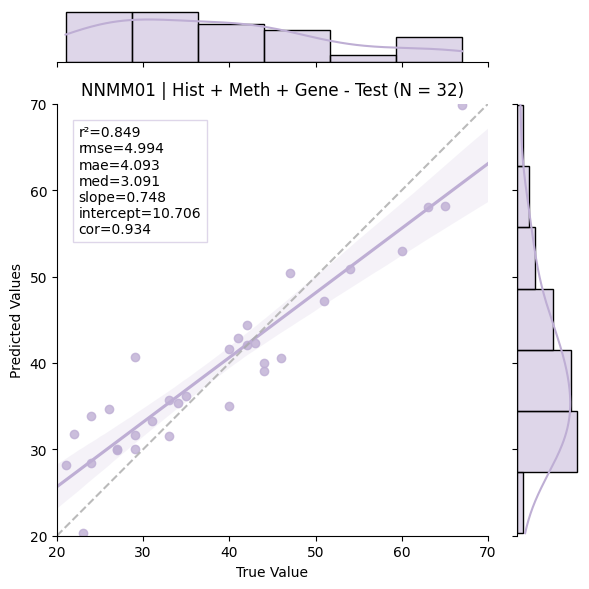

In [108]:
plots.plot_model_fit(
    y_true, 
    y_pred, 
    data_modality="Hist + Meth + Gene", 
    data_set="Test",
    smoker_status=None, 
    color="#BEAED4",
    model = "NNMM01",
    title_override=None,
    fig_output_path=None
    )

# References

Deep Learning:
- HIPT architecture for WSIs:
  - https://github.com/mahmoodlab/HIPT [*Source and Examples*]
  - https://arxiv.org/abs/2206.02647 [*Paper*]
- Extracting 4092x4092 patches from WSIs </br> (*Note: for this task, we got some inspiration from a caption generation work in histology. They are also using HIPT and for that they developed a code to extract these patches.*):
  - https://arxiv.org/pdf/2312.01435.pdf [*Paper*]
  - https://github.com/ssen7/histo_cap_transformers [*Code*]

Parameter/Hyperparameter tuning:
- Ray Tune in PyTorch [*Not Used*]:
  - https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
- SpotPython [*Not Used*]:
  - https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb
- Cross-validation with Optuna and PyTorch:
  - https://stackoverflow.com/questions/63224426/how-can-i-cross-validate-by-pytorch-and-optuna
  - https://colab.research.google.com/drive/1wCQw3NTad2S4kXxxAqN0WjORhiqyVV2v?usp=sharing#scrollTo=R2H8bU_tJGRD
- Optuna implementation examples:
  - https://github.com/optuna/optuna-examples/tree/main/pytorch
  - https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py

Imbalanced data in regression problems:
- New tchniques LDS and FDS:
  - http://dir.csail.mit.edu [*Project Page*]
  - https://arxiv.org/pdf/2102.09554.pdf [*Paper*]
  - https://github.com/YyzHarry/imbalanced-regression [*PyTorch Implementation*]